In [223]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

# Get the data this is from the sample code
data1 = np.loadtxt("HARPS.dat")
data2 = np.loadtxt("HIRES.dat")
print(len(data1), ' HARPS points; ', len(data2), ' HIRES points')

# Transpose the data for contiguity reasons (we need each variable to be contiguous for numba)
data = np.hstack((data1.T, data2.T)).copy("C")

# Add on jitter (additional noise term)
jitter = 1.2
data[2] = np.sqrt(data[2]**2 + jitter**2)

# Initial information from Vogt et al. (2010)
Pb_sol = 5.36841; Pb_del = 0.00026; Kb_sol = 12.45
Pc_sol = 12.9191; Pc_del = 0.0058;  Kc_sol = 3.30
Pd_sol = 66.87;   Pd_del = 0.13;    Kd_sol = 1.91
Pe_sol = 3.14867; Pe_del = 0.00039; Ke_sol = 1.66
Pf_sol = 433.0;   Pf_del = 13.0;    Kf_sol = 1.30
Pg_sol = 36.562;  Pg_del = 0.052;   Kg_sol = 1.29

119  HARPS points;  122  HIRES points


In [141]:
# Since we'll be using these numbers a lot, let's move the data from
# hard coded variables into a DataFrame we can manipulate easier
df_sol = pd.DataFrame(
    (
        (Pb_sol, Pb_del, Kb_sol),
        (Pc_sol, Pc_del, Kc_sol),
        (Pd_sol, Pd_del, Kd_sol),
        (Pe_sol, Pe_del, Ke_sol),
        (Pf_sol, Pf_del, Kf_sol),
        (Pg_sol, Pg_del, Kg_sol)
    ),
    columns=["P", "P_del", "K"],
    index=["b", "c", "d", "e", "f", "g"]
)
df_sol

,P,P_del,K
b,5.36841,0.00026,12.45
c,12.91910,0.00580,3.30
d,66.87000,0.13000,1.91
e,3.14867,0.00039,1.66
f,433.00000,13.00000,1.30
g,36.56200,0.05200,1.29


In [142]:
# Define the model M0 with the confirmed planets b, c, d, e
df_M0 = df_sol.loc[["b", "c", "d", "e"]]

# Define the model Mf with the confirmed planets b, c, d, e and f
df_Mf = df_sol.loc[["b", "c", "d", "e", "f"]]

# Define the model Mf with the confirmed planets b, c, d, e and g
df_Mg = df_sol.loc[["b", "c", "d", "e", "g"]]

# Define the model Mf with the confirmed planets b, c, d, e and both f and g
df_Mfg = df_sol.loc[["b", "c", "d", "e", "f", "g"]]


# Definitely incorrect models
# Include these to make sure our calculated statistics make sense, they should
# perform much worse than M_0
df_Mbc = df_sol.loc[["b", "c"]]
df_Mbcd = df_sol.loc[["b", "c", "d"]]

In [219]:
# A full fit is tricky because it's not obvious where to initalize the phases (q) from
# So let's run a pre-fit first, where we only allow the phases to vary
# Trying running this a few times and make sure the same solution is coming out

# I make the fitting functions re-usable for the three cases we're considering by removing
# anything hard coding the functions to specific planets

# Define the constant 2*pi since we're using it a lot
_2PI = 2. * np.pi 

# the least_squares method in scipy defines various tolerances that allow us
# to tune how much precision we want in our fit.

# For the large MC ensemble, high precision is not necessary and we can save a lot of time
# by defining more lenient tolerances
MC_TOLS = dict(
    ftol=1e-05,
    xtol=1e-05,
    gtol=1e-05,
)

# These are the default tolerances in scipy
DEFAULT_TOLS = dict(
    ftol=1e-08,
    xtol=1e-08,
    gtol=1e-08,
)

# Define model Mfix = N model using K & P parameters fixed to the Vogt+ reported values
# Fits to all planets in df. Ensure that the array q has the same length as df.
def Mfix(df):
    K = df["K"].to_numpy().reshape(1, -1)
    P = df["P"].to_numpy().reshape(1, -1)

    # @ngjit
    def _Mfix(t, *args):
        return np.sum(K * np.sin(_2PI * np.reshape(t, (-1, 1)) / P + np.asarray(args)), axis=1)
    return _Mfix

# This function performs the curve fit for the phases based on the model "Mfix"
# returned by the function above
def fix_phases(n_p, Mfix, data=data, tols=DEFAULT_TOLS):
    # Define our parameters bounds
    param_bounds = (
        np.full(n_p, -_2PI),
        np.full(n_p,  _2PI),
    )

    # Give an intial guess to help the fitting routine
    initial_guess = np.random.uniform(-_2PI, _2PI, size=n_p)
    # Doing the curve fit
    Mfix_best, _ = curve_fit(Mfix,
        data[0], data[1], sigma=data[2],
        p0=initial_guess, bounds=param_bounds, **tols)

    modeled = Mfix(data[0], *Mfix_best)

    # returns the parameters and the model at each data point
    return Mfix_best, modeled

In [169]:
# Like in the sample code, calculate initial fits for the phases and the corresponding
# chi^2 to check that it is working
M0_phases, M0_phase_fix_fit = fix_phases(len(df_M0), Mfix(df_M0), data)

# Calculate chi^2 from the residuals and the reported errors on the velocities
chi2 = np.sum(((data[1] - M0_phase_fix_fit) / data[2])**2)

# Print output
print(chi2, len(data))

395.79612572946564 3


In [224]:
# Now we're ready to run the full N-planet fit

# This function will work for any number of planets, so we don't need to define
# new model functions.

# As in the example code, treat every three elements of args as (Ki, Pi, qi)
# using some reshaping magic
def M(t, *args):
    K, P, q = np.reshape(np.asarray(args), (-1, 1, 3)).T
    return np.sum(K * np.sin(_2PI * np.reshape(t, (-1, 1)) / P + q), axis=1)

# I separated out the code for initializing the parameter boundaries since
# we don't need to recalculate for each fit with a model when we do the
# full cross-validation model selection
def full_fit_param_bounds(df_model):
    # curve_fit expects a (3*n_p, 2) array, where we've flattened the parameters
    # into [(K_1, P_1, Q_1, K_2, P_2, Q_2...), (K_1, P_1, Q_1, K_2, P_2, Q_2...)]
    param_bounds = np.empty((2, len(df_model)*3), dtype=np.float64)

    # We transpose and and reshape the array to create a view
    # where we can set each parameter K, Q, and P with a n_p x 3 x 2
    # input array, which is more natural for bounds
    param_bounds_S = param_bounds.T.reshape(-1, 3, 2)

    # K bounds
    param_bounds_S[:, 0, :] = (0., 20.)
    # P bounds (+/- 3 sigma)
    param_bounds_S[:, 1, :] = np.transpose([
        df_model["P"] - 3. * df_model["P_del"],
        df_model["P"] + 3. * df_model["P_del"]
    ])

    # q bounds
    param_bounds_S[:, 2, :] = (-_2PI, _2PI)

    return param_bounds

# This function performs the full fit for K, P and q based on initial guesses from
# the data frame df_model and the pre-fit phases q.
# param_bounds can be optionally supplied by the caller (to avoid recalculating it)
def full_fit(df_model, q, data=data, param_bounds=None, tols=DEFAULT_TOLS):
    if param_bounds is None:
        param_bounds = full_fit_param_bounds(df_model)

    # Give an intial guess to help the fitting routine
    # Initialize it as a N x 3 array, and ravel/flatten it when
    # we pass it to curve_fit. The rows are K, P, and q
    initial_guess = np.empty((len(df_model), 3), dtype=np.float64)
    initial_guess[:, 0] = df_model["K"].to_numpy()
    initial_guess[:, 1] = df_model["P"].to_numpy()
    initial_guess[:, 2] = q

    # Get the best fitting parameters
    M_best, _ = curve_fit(M,
        data[0], data[1], sigma=data[2],
        p0=initial_guess.ravel(), bounds=param_bounds, **tols)

    modeled = M(data[0], *M_best)

    # returns the parameters and the model at each data point
    return M_best, modeled

In [198]:
# Like in the sample code, calculate initial fits on M0 and the corresponding
# chi^2 to check that it is working
M0_best, M0_fit = full_fit(df_M0, M0_phases, data, tols=MC_TOLS)

# Get the chi2
chi2 = np.sum(((data[1] - M0_fit) / data[2])**2)

# Get the loglike
loglike = -0.5*data.shape[1]*np.log(_2PI) - np.sum(np.log(data[2])) - 0.5*chi2

# print the chi2 and loglike
print(chi2, loglike)

390.5315197034038 -567.8480597377704


In [200]:
# From Nitya, functions to calculate various model comparison metrics from
# the chi^2, n (number of data points) and k (number of free parameters in model)

# Refer to the lecture slides for the source of the formulas

def reduced_chi2(chi2, n, k):
    return chi2 / (n - k)

def BIC(chi2, n, k):
    return chi2 + k * np.log(n)

def AIC(chi2, k):
    return chi2 + 2 * k

def mod_AIC(chi2, n, k):
    return AIC(chi2, k) + (2*k**2 + 2*k)/(n - k - 1)

def BIC_bayes(bic1, bic2):
    return np.exp(-0.5*(bic1-bic2))

In [225]:
# For a certain model with pre-determined parameter guesses in the dataframe df_model,
# performs the fit shown above on the data in data_train, and returns various metrics
# of model performance on data_val as a dictionary.
def eval_all_model(df_model, data_train, data_val):
    # Do the phase pre-fit
    q, _= fix_phases(len(df_model), Mfix(df_model), data_train)
    # Fit all the parameters
    best_fit, _ = full_fit(df_model, q, data_train)

    # Compute the chi^2 and log likelihood as above
    chi2 = np.sum(((data_val[1] - M(data_val[0], *best_fit)) / data_val[2])**2)
    loglike = -0.5*data_val.shape[1]*np.log(_2PI) - np.sum(np.log(data_val[2])) - 0.5*chi2

    # n (number of data points) and k (number of free parameters in model)
    n = data_val.shape[1]
    k = len(df_model) * 3
    return {
        "chi2": chi2,
        "loglike": loglike,
        "reduced_chi2": reduced_chi2(chi2, n, k),
        "BIC": BIC(chi2, n, k),
        "AIC": AIC(chi2, k),
        "mod_AIC": mod_AIC(chi2, n, k),
    }

df_compare = pd.DataFrame({
    "$M_{bc}$": eval_all_model(df_Mbc, data, data),
    "$M_{bcd}$": eval_all_model(df_Mbcd, data, data),
    "$M_0$": eval_all_model(df_M0, data, data),
    "$M_f$": eval_all_model(df_Mf, data, data),
    "$M_g$": eval_all_model(df_Mg, data, data),
    "$M_{fg}$": eval_all_model(df_Mfg, data, data)
}).transpose()
df_compare

,chi2,loglike,reduced_chi2,BIC,AIC,mod_AIC
$M_{bc}$,588.539374,-666.851987,2.504423,621.448155,600.539374,600.898348
$M_{bcd}$,492.452971,-618.808786,2.122642,541.816144,510.452971,511.232192
$M_0$,392.009919,-568.587259,1.711834,457.827482,416.009919,417.378340
$M_f$,346.568248,-545.866424,1.533488,428.840202,376.568248,378.701582
$M_g$,341.939144,-543.551872,1.513005,424.211098,371.939144,374.072478
$M_{fg}$,298.026431,-521.595515,1.336441,396.752775,334.026431,337.107512


In [226]:
print(df_compare.style.format(precision=2)
      .format_index(escape="latex", axis=1)
      .to_latex())

\begin{tabular}{lrrrrrr}
 & chi2 & loglike & reduced\_chi2 & BIC & AIC & mod\_AIC \\
$M_{bc}$ & 588.54 & -666.85 & 2.50 & 621.45 & 600.54 & 600.90 \\
$M_{bcd}$ & 492.45 & -618.81 & 2.12 & 541.82 & 510.45 & 511.23 \\
$M_0$ & 392.01 & -568.59 & 1.71 & 457.83 & 416.01 & 417.38 \\
$M_f$ & 346.57 & -545.87 & 1.53 & 428.84 & 376.57 & 378.70 \\
$M_g$ & 341.94 & -543.55 & 1.51 & 424.21 & 371.94 & 374.07 \\
$M_{fg}$ & 298.03 & -521.60 & 1.34 & 396.75 & 334.03 & 337.11 \\
\end{tabular}



In [227]:
from math import comb
from itertools import combinations
import time

def eval_chi2_model(model, data_train, data_val):
    df_model, Mfix, param_bounds = model
    q, _= fix_phases(len(df_model), Mfix, data_train)
    
    # Use the lenient tolerances from above for the MC ensemble
    best_fit, _ = full_fit(df_model, q, data_train, param_bounds, tols=MC_TOLS)

    return np.sum(((data_val[1] - M(data_val[0], *best_fit)) / data_val[2])**2)

def _leave_p_out_non_exhaustive(n, p, trials):
    for _ in range(trials):
        yield np.random.choice(n, size=p, replace=False)

def crossval_leave_p_out(models, p, data, trials=None, _id=None, seed=None):
    if seed:
        np.random.seed(seed)

    n = data.shape[1]

    if trials is None:
        _iter = combinations(n, p)
        trials = comb(n, p)
    else:
        _iter = _leave_p_out_non_exhaustive(n, p, trials)

    start_time = time.time()
    print(f"Started Worker {_id} with seed {seed}: 0/{trials}")

    _tidx = np.zeros(data.shape[1], dtype=bool)

    chi2 = np.empty((trials, len(models)), dtype=np.float64)
    loglike = np.empty((trials, len(models)), dtype=np.float64)

    _models = [(df_model, Mfix(df_model), full_fit_param_bounds(df_model)) for df_model in models]

    for i, val_idx in enumerate(_iter):
        _tidx[:] = True
        _tidx[val_idx] = False

        data_train = data[:, _tidx].copy("C")
        data_val = data[:, val_idx].copy("C")

        for j, model in enumerate(_models):
            chi2[i, j] = _chi2 = eval_chi2_model(model, data_train, data_val)
            loglike[i, j] = -0.5*data_val.shape[1]*np.log(_2PI) - np.sum(np.log(data_val[2])) - 0.5*_chi2

        if _id is not None and (i + 1) % 100 == 0:
            print(f"Worker {_id}: {i + 1}/{trials}, in {time.time()-start_time}s")

    return chi2, loglike

In [228]:
import multiprocessing
from functools import partial
from os import cpu_count

nproc = cpu_count()
trials = 10000
p = 3

f = partial(
    crossval_leave_p_out,
    [df_Mbc, df_Mbcd, df_M0, df_Mf, df_Mg, df_Mfg],
    p, data
)

s_trials = (trials // nproc) + 1
trials_i = [s_trials] * (nproc - 1) + [trials - s_trials * (nproc - 1)]

seeds = np.random.choice(np.iinfo(np.int32).max, size=nproc)
with multiprocessing.Pool(nproc) as p:
    chi2s = p.starmap(f, zip(trials_i, range(nproc), seeds))

Started Worker 2 with seed 1460983973: 0/1251Started Worker 1 with seed 2111289671: 0/1251
Started Worker 3 with seed 490956569: 0/1251Started Worker 7 with seed 613857384: 0/1243Started Worker 5 with seed 2050864047: 0/1251
Started Worker 4 with seed 2097045773: 0/1251

Started Worker 6 with seed 716543577: 0/1251


Started Worker 0 with seed 976677946: 0/1251
Worker 2: 100/1251, in 42.7525908946991s
Worker 7: 100/1243, in 42.78801941871643s
Worker 3: 100/1251, in 43.09004878997803s
Worker 5: 100/1251, in 43.20674467086792s
Worker 6: 100/1251, in 45.85727000236511s
Worker 4: 100/1251, in 46.314470291137695s
Worker 0: 100/1251, in 47.4811794757843s
Worker 1: 100/1251, in 48.26877236366272s
Worker 7: 200/1243, in 90.51183152198792s
Worker 5: 200/1251, in 90.532142162323s
Worker 3: 200/1251, in 91.07720637321472s
Worker 4: 200/1251, in 93.19905591011047s
Worker 2: 200/1251, in 96.26790022850037s
Worker 6: 200/1251, in 98.24460983276367s
Worker 0: 200/1251, in 99.86933469772339s
Worker 1:

In [238]:
chi2_c = np.concatenate([chi2 for chi2, _ in chi2s])
best_models = np.argmin(chi2_c, axis=1)

In [231]:
import matplotlib

CUSTOM_PLOT_STYLE = {
    "text.usetex": True,

    "font.family": "serif",
    "font.size": 16,

    # Set some default sizes, so we don't need to include them in each call
    "lines.markersize": 1.5,
    "lines.linewidth": 1.5,
    # "errorbar.capsize": 3,

    # Set savefig to use bbox_inches="tight" by default
    "savefig.bbox": "tight",
    "savefig.facecolor": "none",
    "savefig.dpi": 300,

    # Higher DPI for sharper inline images
    "figure.dpi": 96
}

matplotlib.rcdefaults()
matplotlib.rcParams.update(CUSTOM_PLOT_STYLE)

In [249]:
# Define a color palette of four colors for the four models (0, f, g, fg)
MODEL_COLORS = [
    '#D93472',
    '#D90812',
    '#222222',
    '#248394',
    '#F29E02',
    '#399359',
]

# Define the mathtext/latex labels for the models in the plots
MODEL_NAMES = [
    "$M_{bc}$",
    "$M_{bcd}$",
    "$M_0$",
    "$M_f$",
    "$M_g$",
    "$M_{fg}$",
]

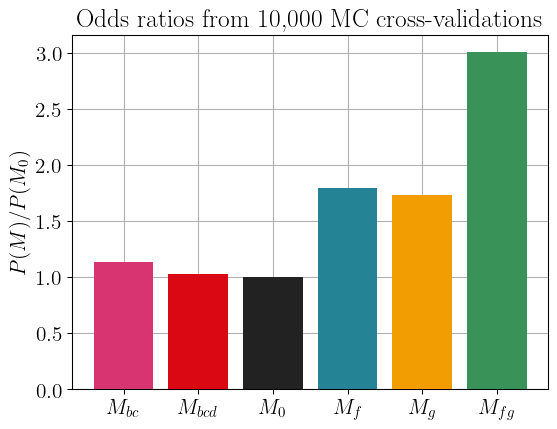

In [250]:
import matplotlib.pyplot as plt

idx = np.arange(len(MODEL_NAMES))
counts = [np.sum(best_models == i) for i in idx]
odds_ratios = counts / np.float64(counts[2])

fig, ax = plt.subplots()

ax.grid(zorder=0)
ax.bar(idx, counts / np.float64(counts[2]), zorder=3, color=MODEL_COLORS)
ax.set_xticks(idx)
ax.set_xticklabels(MODEL_NAMES)
ax.set_ylabel("$P(M) / P(M_0)$")
ax.set_title("Odds ratios from 10,000 MC cross-validations")

# plt.savefig("odds.png")
plt.show()

In [354]:
odds_ratios

array([1.        , 1.54183007, 1.49150327, 2.50261438])

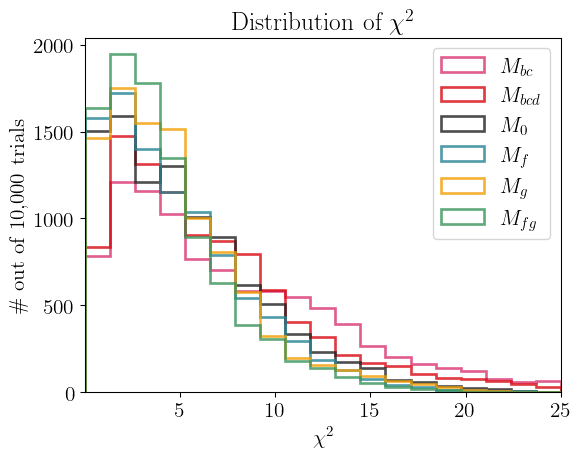

In [252]:
fig, ax = plt.subplots()

for i, (c, l) in enumerate(zip(MODEL_COLORS, MODEL_NAMES)):
    ax.hist(chi2_c[:, i], color=c, histtype='step', bins=np.linspace(0, 25, 20), alpha=0.8, lw=2, label=l)

ax.set_xlabel(r"$\chi^2$")
ax.set_ylabel(r"\# out of 10,000 trials")
ax.set_xlim(0.01, 25)
ax.set_title(r"Distribution of $\chi^2$")
ax.legend()

plt.savefig("chi2.png")
plt.show()